In [1]:
import torchvision.datasets as datasets

# Download the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import datetime

# Set device to GPU 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Custom Transformer Encoder Layer to capture attention weights
class CustomTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super(CustomTransformerEncoderLayer, self).__init__(*args, **kwargs)
        self.attention_weights = None

    def forward(self, src, *args, **kwargs):
        src2, attn_weights = self.self_attn(src, src, src, attn_mask=kwargs.get('attn_mask'), key_padding_mask=kwargs.get('key_padding_mask'))
        self.attention_weights = attn_weights
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

# Define the Vision Transformer model with attention visualization
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, num_classes=10, dim=128, depth=6, heads=8, mlp_dim=256, dropout=0.1):
        super(VisionTransformer, self).__init__()
        assert img_size % patch_size == 0, 'Image size must be divisible by the patch size'
        num_patches = (img_size // patch_size) ** 2
        patch_dim = 3 * patch_size ** 2

        self.patch_size = patch_size
        self.dim = dim

        self.patch_embeddings = nn.Linear(patch_dim, dim)
        self.positional_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(dropout)

        self.transformer_layers = nn.ModuleList([
            CustomTransformerEncoderLayer(dim, heads, mlp_dim, dropout, batch_first=True) for _ in range(depth)
        ])

        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        p = self.patch_size
        x = x.view(x.size(0), 3, p, p, -1)
        x = x.permute(0, 4, 1, 2, 3).contiguous().view(x.size(0), -1, 3 * p ** 2)
        x = self.patch_embeddings(x)
        b, n, _ = x.size()

        cls_tokens = self.cls_token.expand(b, -1, -1)
        print(cls_tokens.shape,x.shape)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.positional_embeddings[:, :(n + 1)]
        x = self.dropout(x)

        self.attn_weights = []

        for layer in self.transformer_layers:
            x = layer(x)
            self.attn_weights.append(layer.attention_weights)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

    def get_attention_map(self):
        return self.attn_weights

def visualize_attention(model, dataloader, num_images=5):
    model.eval()
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)

    with torch.no_grad():
        _ = model(images)

    attn_weights = model.get_attention_map()

    for i, img in enumerate(images.cpu()):
        img = img.permute(1, 2, 0).numpy()
        print(f"Image shape: {img.shape}")
        plt.figure(figsize=(10, 10))
        plt.subplot(1, num_images + 1, 1)
        plt.imshow((img - img.min()) / (img.max() - img.min()))
        plt.axis('off')
        plt.title('Original')

        for j, attn in enumerate(attn_weights):
            print(f"Attention weight shape (layer {j+1}): {attn.shape}")
            attn = attn[i, 0, 1:].mean(dim=0)
            print(f"Mean attention shape: {attn.shape}")
            attn = attn.reshape(int(np.sqrt(attn.shape[0])), int(np.sqrt(attn.shape[0]))).cpu().numpy()  # Adjust reshape dynamically
            print(f"Reshaped attention shape: {attn.shape}")
            attn = (attn - attn.min()) / (attn.max() - attn.min())
            plt.subplot(1, num_images + 1, j + 2)
            plt.imshow(attn, cmap='inferno')
            plt.axis('off')
            plt.title(f'Layer {j + 1}')

        plt.show()

# print the dimension of images to verify all loaders have the same dimensions
def print_dim(loader, text):
  print('---------'+text+'---------')
  print(len(loader.dataset))
  for image, label in loader:
    print(image.shape)
    print(label.shape)
    break
      
# Prepare the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print_dim(train_loader,'training loader')
# print_dim(val_loader,'validation loader')
print_dim(test_loader,'test loader')

Files already downloaded and verified
Files already downloaded and verified
---------training loader---------
50000
torch.Size([64, 3, 32, 32])
torch.Size([64])
---------test loader---------
10000
torch.Size([64, 3, 32, 32])
torch.Size([64])


torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.Size([64, 64, 128])
torch.Size([64, 1, 128]) torch.

IndexError: tuple index out of range

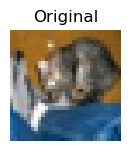

In [3]:

# Instantiate the model, loss function, and optimizer
model = VisionTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set up TensorBoard
run_name = 'VisualTest'
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f'runs/vit_{run_name}_{current_time}'
writer = SummaryWriter(log_dir)

# Training loop
def train(model, loader, criterion, optimizer, writer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:    # Log every 100 mini-batches
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(loader)}], Loss: {running_loss / 100:.4f}')
                writer.add_scalar('training loss', running_loss / 100, epoch * len(loader) + i)
                running_loss = 0.0

                # Log the model predictions
                with torch.no_grad():
                    sample_images = images[:8]
                    sample_outputs = model(sample_images)
                    _, preds = torch.max(sample_outputs, 1)
                    grid = vutils.make_grid(sample_images)
                    writer.add_image('images', grid, epoch * len(loader) + i)
                    writer.add_text('predictions', ' '.join(f'{pred}' for pred in preds), epoch * len(loader) + i)

# Evaluate the model on the test dataset
def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    test_loss /= len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

train(model, train_loader, criterion, optimizer, writer, epochs=10)
writer.close()

# Evaluate the model on test data
test(model, test_loader, criterion)

# Visualize attention maps
visualize_attention(model, test_loader, num_images=5)

# Release GPU resources
del model
torch.cuda.empty_cache()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import datetime

# Set device to GPU 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Function to convert image to patches
def img_to_patch(x, patch_size, flatten_channels=True):
    B, C, H, W = x.shape  # [B, C, H, W], CIFAR-10 [B, 3, 32, 32]
    assert H % patch_size == 0 and W % patch_size == 0, "Image dimensions must be divisible by the patch size."
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)  # [B, C, H', p_H, W', p_W]
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

# Custom Transformer Encoder Layer to capture attention weights
class CustomTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super(CustomTransformerEncoderLayer, self).__init__(*args, **kwargs)
        self.attention_weights = None

    def forward(self, src, *args, **kwargs):
        src2, attn_weights = self.self_attn(src, src, src, attn_mask=kwargs.get('attn_mask'), key_padding_mask=kwargs.get('key_padding_mask'))
        self.attention_weights = attn_weights
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

# Define the Vision Transformer model with attention visualization
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, num_classes=10, dim=128, depth=6, heads=8, mlp_dim=256, dropout=0.1):
        super(VisionTransformer, self).__init__()
        assert img_size % patch_size == 0, 'Image size must be divisible by the patch size'
        num_patches = (img_size // patch_size) ** 2
        patch_dim = 3 * patch_size ** 2

        self.patch_size = patch_size
        self.dim = dim

        self.patch_embeddings = nn.Linear(patch_dim, dim)
        self.positional_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(dropout)

        self.transformer_layers = nn.ModuleList([
            CustomTransformerEncoderLayer(dim, heads, mlp_dim, dropout, batch_first=True) for _ in range(depth)
        ])

        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        p = self.patch_size
        x = img_to_patch(x, p)  # Convert image to patches
        b, n, _ = x.size()
        print(f"Patches shape: {x.shape}")

        cls_tokens = self.cls_token.expand(b, -1, -1)
        print(f"CLS token shape: {cls_tokens.shape}")
        x = torch.cat((cls_tokens, x), dim=1)
        print(f"Concatenated shape: {x.shape}")
        x += self.positional_embeddings[:, :(n + 1)]
        x = self.dropout(x)

        self.attn_weights = []

        for layer in self.transformer_layers:
            x = layer(x)
            self.attn_weights.append(layer.attention_weights)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

    def get_attention_map(self):
        return self.attn_weights

# Visualize attention maps for a single image
def visualize_attention_single_image(model, dataloader, image_idx=0):
    model.eval()
    images, _ = next(iter(dataloader))
    image = images[image_idx:image_idx+1].to(device)  # Select a single image

    with torch.no_grad():
        _ = model(image)

    attn_weights = model.get_attention_map()
    img = image.cpu().squeeze().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())

    plt.figure(figsize=(10, 10))
    plt.subplot(1, len(attn_weights) + 1, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original')

    for j, attn in enumerate(attn_weights):
        print(f"Attention weight shape (layer {j+1}): {attn.shape}")
        attn = attn[0, 0, 1:].mean(dim=0)
        print(f"Mean attention shape: {attn.shape}")
        try:
            attn = attn.reshape(int(np.sqrt(attn.shape[0])), int(np.sqrt(attn.shape[0]))).cpu().numpy()
            print(f"Reshaped attention shape: {attn.shape}")
            attn = (attn - attn.min()) / (attn.max() - attn.min())
            plt.subplot(1, len(attn_weights) + 1, j + 2)
            plt.imshow(attn, cmap='inferno')
            plt.axis('off')
            plt.title(f'Layer {j + 1}')
        except Exception as e:
            print(f"Error reshaping attention: {e}")

    plt.show()

# Prepare the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Instantiate the model, loss function, and optimizer
model = VisionTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set up TensorBoard
run_name = 'VisualTest'
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f'runs/vit_{run_name}_{current_time}'
writer = SummaryWriter(log_dir)

# Training loop
def train(model, loader, criterion, optimizer, writer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:    # Log every 100 mini-batches
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(loader)}], Loss: {running_loss / 100:.4f}')
                writer.add_scalar('training loss', running_loss / 100, epoch * len(loader) + i)
                running_loss = 0.0

                # Log the model predictions
                with torch.no_grad():
                    sample_images = images[:8]
                    sample_outputs = model(sample_images)
                    _, preds = torch.max(sample_outputs, 1)
                    grid = vutils.make_grid(sample_images)
                    writer.add_image('images', grid, epoch * len(loader) + i)
                    writer.add_text('predictions', ' '.join(f'{pred}' for pred in preds), epoch * len(loader) + i)

# Evaluate the model on the test dataset
def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    test_loss /= len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

train(model, train_loader, criterion, optimizer, writer, epochs=10)
writer.close()

# Evaluate the model on test data
test(model, test_loader, criterion)

# Visualize attention maps for a single image
visualize_attention_single_image(model, test_loader, image_idx=0)

# Release GPU resources
del model
torch.cuda.empty_cache()
